# Wikimedia Data Challenge

## Introduction
This Project was put out as data challenge by the <a href="https://wikimediafoundation.org/wiki/Home">Wikimedia Foundation</a> for a data analyst position. I thought it would be a great opportunity to brush up on some data analysis tools in Pandas and decided to complete the challenge.


The goal of the project was to analyze data from *event logging* (EL) to track a variety of performance and usage metrics to help them make decisions. Specifically, they were interested in:

- *clickthrough rate*: the proportion of search sessions where the user clicked on one of the results displayed
- *zero results rate*: the proportion of searches that yielded 0 results

EL uses JavaScript to asynchronously send messages (events) to their servers when the user has performed specific actions. 


## Data

The dataset comes from a [tracking schema](3) that they use for assessing user satisfaction. Desktop users are randomly sampled to be anonymously tracked by this schema which uses a "I'm alive" pinging system that we can use to estimate how long our users stay on the pages they visit. The dataset contains just a little more than a week of EL data.

| Column          | Value   | Description                                                                       |
|:----------------|:--------|:----------------------------------------------------------------------------------|
| uuid            | string  | Universally unique identifier (UUID) for backend event handling.                  |
| timestamp       | integer | The date and time (UTC) of the event, formatted as YYYYMMDDhhmmss.                |
| session_id      | string  | A unique ID identifying individual sessions.                                      |
| group           | string  | A label ("a" or "b").                                     |
| action          | string  | Identifies in which the event was created. See below.                             |
| checkin         | integer | How many seconds the page has been open for.                                      |
| page_id         | string  | A unique identifier for correlating page visits and check-ins.                    |
| n_results       | integer | Number of hits returned to the user. Only shown for searchResultPage events.      |
| result_position | integer | The position of the visited page's link on the search engine results page (SERP). |

The following are possible values for an event's action field:

- **searchResultPage**: when a new search is performed and the user is shown a SERP.
- **visitPage**: when the user clicks a link in the results.
- **checkin**: when the user has remained on the page for a pre-specified amount of time.

### Example Session

|uuid                             |      timestamp|session_id       |group |action           | checkin|page_id          | n_results| result_position|
|:--------------------------------|:--------------|:----------------|:-----|:----------------|-------:|:----------------|---------:|---------------:|
|4f699f344515554a9371fe4ecb5b9ebc | 20160305195246|001e61b5477f5efc |b     |searchResultPage |      NA|1b341d0ab80eb77e |         7|              NA|
|759d1dc9966353c2a36846a61125f286 | 20160305195302|001e61b5477f5efc |b     |visitPage        |      NA|5a6a1f75124cbf03 |        NA|               1|
|77efd5a00a5053c4a713fbe5a48dbac4 | 20160305195312|001e61b5477f5efc |b     |checkin          |      10|5a6a1f75124cbf03 |        NA|               1|
|42420284ad895ec4bcb1f000b949dd5e | 20160305195322|001e61b5477f5efc |b     |checkin          |      20|5a6a1f75124cbf03 |        NA|               1|
|8ffd82c27a355a56882b5860993bd308 | 20160305195332|001e61b5477f5efc |b     |checkin          |      30|5a6a1f75124cbf03 |        NA|               1|
|2988d11968b25b29add3a851bec2fe02 | 20160305195342|001e61b5477f5efc |b     |checkin          |      40|5a6a1f75124cbf03 |        NA|               1|

This user's search query returned 7 results, they clicked on the first result, and stayed on the page between 40 and 50 seconds. (The next check-in would have happened at 50s.)

[1]: https://www.mediawiki.org/wiki/Wikimedia_Discovery
[2]: https://wikimediafoundation.org/wiki/Home
[3]: https://meta.wikimedia.org/wiki/Schema:TestSearchSatisfaction2


## Objectives

The objectives of this project are to find answers to the following questions:

1. What is their daily overall clickthrough rate? How does it vary between the groups?
2. Which results do people tend to try first? How does it change day-to-day?
3. What is their daily overall zero results rate? How does it vary between the groups?
4. Let *session length* be approximately the time between the first event and the last event in a session. Choose a variable from the dataset and describe its relationship to session length. Visualize the relationship.



We'll dive in to the data analysis below, but first well read in some basic libraries as well as write some functions which we will use later on.

In [1]:
import pandas as pd
import numpy as np
import os.path
import pandas as pd
import matplotlib.pyplot as plt
% matplotlib inline

def read_in_data():
    """
    Does the following,
    
    1.) Reads in the csv file:
    
        'events_logs.csv'
    
    and set the index to be the timestamp and print its to a
    new file called:
        
        'new_events_log.csv'
        
    2.) Then it just reads in'new_events_log.csv' and returns the
    corresponding dataframe.
    
    If the file 'new_events_log.csv'already exists then only 2. is done.
    
    :return: Dataframe of the data.
    
    :rvalue: Pandas DataFrame.
    
    """
    # 1.)
    if os.path.isfile('new_events_log.csv') is False:
        df = pd.read_csv("events_log.csv")
        df['timestamp'] = df['timestamp'].astype(int)
        df.to_csv('new_events_log.csv')
    
    #2.) 
    df = pd.read_csv("new_events_log.csv",
                     parse_dates=['timestamp'], 
                     index_col='timestamp')
    
    # drop some extra column
    df = df.drop('Unnamed: 0',axis=1)
    
    return df

def searched_per_day_by_group(df):
    """
    Returns the number of searches per day by group 'a' vs. 'b'
    
    :param: df: Pandas dataframe indexed by pandas.DateTime
    
    :returns: Series with the day and the number of searches
              in that day by group 'a' vs. 'b'
    
    :rvalue: Pandas Series
    """
    return df.groupby([pd.TimeGrouper('D'),'group']).apply(lambda row: 
                                                           len(row[row['action'] == 'searchResultPage']))


def searched_per_day(df):
    """
    Returns the number of searches per day
    
    :param: df: Pandas dataframe indexed by pandas.DateTime
    
    :returns: Series with the day and the percentage of searches in that day
    
    :rvalue: Pandas Series
    """
    return df.groupby([pd.TimeGrouper('D')]).apply(lambda row: 
                                                   len(row[row['action'] == 'searchResultPage']))


def average_click_through_rate(df):
    """
    Returns the average number of clickthroughs per day
    
    :param: df: Pandas dataframe indexed by pandas.DateTime
    
    :returns: Series with the day and the percentage of clickthroughs 
              in that day 
    
    :rvalue: float
    """
    # click through by day
    CT_PerDay = df.groupby([pd.TimeGrouper('D')]).apply(lambda row: 
                                                           len(row[row['action'] == 'visitPage']))
    
    Searches_PerDay = searched_per_day(df)
    
    Daily_Averages = CT_PerDay / Searches_PerDay
    
    return Daily_Averages.mean()


def average_click_through_rate_by_group(df):
    """
    Returns the average number of clickthroughs per day by group 'a' vs. 'b'
    
    :param: df: Pandas dataframe indexed by pandas.DateTime
    
    :returns: Series with the day and the percentage of clickthroughs 
              in that day by group 'a' vs. 'b'
    
    :rvalue: Pandas Series
    """
    Searches_PerDay_By_Group = searched_per_day_by_group(df)
    CT_PerDay_By_Group = df.groupby([pd.TimeGrouper('D'),'group']).apply(lambda row: 
                                                           len(row[row['action'] == 'visitPage']))

    
    Daily_Averages_By_Group = CT_PerDay_By_Group / Searches_PerDay_By_Group

    # groupby the second entry in the multi-tuple index
    return Daily_Averages_By_Group.groupby(level=[1]).mean()

    
def average_zero_rate(df):
    """
    Returns the average daily number of searches that return zero results.
    
    :param: df: Pandas dataframe indexed by pandas.DateTime
    
    :returns: average daily percentage of searches that return zero results.
    
    :rvalue: float
    """
    Searches_PerDay = searched_per_day(df)
    
    zero_results = df.groupby([pd.TimeGrouper('D')]).apply(lambda row: 
                                                   len(row[row['n_results'] == 0]))
    
    perecent_zeros = zero_results / Searches_PerDay
    
    return perecent_zeros.mean()


def average_zero_rate_by_group(df):
    """
    Returns the average daily number of searches that return zero results by group.
    
    :param: df: Pandas dataframe indexed by pandas.DateTime
    
    :returns: Series with the day and the percentage of searches that return zero results
              in that day by group 'a' vs. 'b'
              
    :rvalue: Pandas Series
    """
    Searches_PerDay_By_Group = searched_per_day_by_group(df)
    
    zero_results = df.groupby([pd.TimeGrouper('D')]).apply(lambda row: 
                                                   len(row[row['n_results'] == 0]))
    
    perecent_zeros = zero_results / Searches_PerDay_By_Group
    
    # groupby the second entry in the multi-tuple index
    return perecent_zeros.groupby(level=[1]).mean()

def plot_scalar(rate, string):
    """
    Function that plots a scalar as bar graph. It replaces the x axis ticks 
    with the str string that is the description of the value to be plotted.
    
    :param: rate (float) : The value to be plotted.
    :param: string (str) : The description of the value to be plotted.
    """
    
    width = 0.25
    width1 = 0.1
    ind = [-0.05]
    plt.bar(ind, rate, width1)
    plt.ylim([0,1])
    plt.xlim([-width, width])
    plt.xticks([0],[string])
    plt.show()
    
    
def plot_grouped(diff, string):
    """
    Function that plots the Pandas Series values as bar graph. 
    
    :param: diff (Pandas Series) : The Series is usually the grouped results.
    :param: string (str) : The description of the value to be plotted.
    """
    diff.plot(kind='bar',title=string)
    plt.xticks(rotation=0)
    plt.ylim([0,1.0])
    plt.show()

## Understanding The Data.
The data was provided in csv format in a file called, "events_log.csv." When reading in the data I wanted to set the index of the dataframe to be timestamp.  This can be achieved using the pandas command:

    df = pd.read_csv("events_log.csv",
                     parse_dates=['timestamp'], 
                     index_col='timestamp')
                  
                  
However, this would not work because the timestamp was being read as an integer in scientific notation and therefore wouldnt convert to DateTime properly. I was able to circumvent this by first reading in the dataframe as usual, then 
changing the timestamp variable to an integer with the command:
    
    df = pd.read_csv('events_log.csv')
    df['timestamp'] = df['timestamp'].astype(int)

I then wrote the dataframe to csv as "new_events_log.csv" and read it in again using the previous technique.  I wanted my code to work even if the person had download the original csv and not the new one.  So,  I wrote a function that did the above if "new_events_log.csv" doesn't exist, and if it did exist just read it in.  This is the funciton called below,

In [2]:
df = read_in_data()

Now, we can get a basic idea of our data by using the info() function:

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 400165 entries, 2016-03-01 10:38:42 to 2016-03-04 14:43:03
Data columns (total 8 columns):
uuid               400165 non-null object
session_id         400165 non-null object
group              400165 non-null object
action             400165 non-null object
checkin            223824 non-null float64
page_id            400165 non-null object
n_results          136234 non-null float64
result_position    230482 non-null float64
dtypes: float64(3), object(5)
memory usage: 27.5+ MB


Let's get an idea of the number of sessions this takes into account for,

In [4]:
session_ids = df.session_id.unique()
print "Number of sessions: " + str(len(session_ids))

Number of sessions: 68028


We can sort the dataframe by session_id to see how long each person stayed on a webpage,

In [5]:
df.sort_values('session_id').head().sort_index()

,uuid,session_id,group,action,checkin,page_id,n_results,result_position
timestamp,,,,,,,,
2016-03-03 15:20:45,e6f9280c8df5536490eb925a91979a3b,0000cbcb67c19c45,b,searchResultPage,NaN,fdeeb9aaf0130d41,20.0,NaN
2016-03-07 08:49:55,5b394c862bf657d98bcd25589a5247ac,0001382e027b2ea4,b,searchResultPage,NaN,7aa28c36c03380a0,18.0,NaN
2016-03-07 08:50:18,f01620582b615c03812cb1af2e804102,0001382e027b2ea4,b,checkin,20.0,f88793c95e778898,NaN,1.0
2016-03-07 08:51:28,fa6a1974487154aa95ddb93d8d5d3734,0001382e027b2ea4,b,checkin,90.0,f88793c95e778898,NaN,1.0
2016-03-07 08:53:28,70d367a1c60156c1b1723d1e4196a987,0001382e027b2ea4,b,checkin,210.0,f88793c95e778898,NaN,1.0


Now let's get into analyzing the data.  

## Analyzing The Data

### Question 1.

We first set out to understand what the average daily click through rate of the users is, we can do this by first finding out how many people visit the page per day.  This is the number the of searches per day, i.e. when each rows has,

    'action' = 'searchResultPage'
    
grouped by day.  We then a need the number of people that visit a page that comes up on the search that is given when each of the rows has, 

    'action' == 'visitPage'
    
grouped by day.  We then divide the two values to get the clickthrough rate.  This is what is completed in 

    average_click_through_rate(...)

and we display the results below:

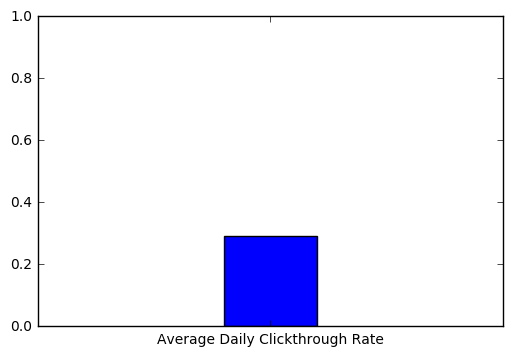

In [6]:
rate = [average_click_through_rate(df)]
plot_scalar(rate, 'Average Daily Clickthrough Rate')

We now have to answer the same question on quick through rate, but also take into account the differences between groups.  This can be achieved using the same procedure as before, but grouping by day as well as the group, i.e.

    df.groupby[pd.TimeGrouper('D'),'group']

and then count the number of rows that have the different actions.  This is what is done in the function, 

    average_click_through_rate_by_group(...) 
    
and we show the results below:

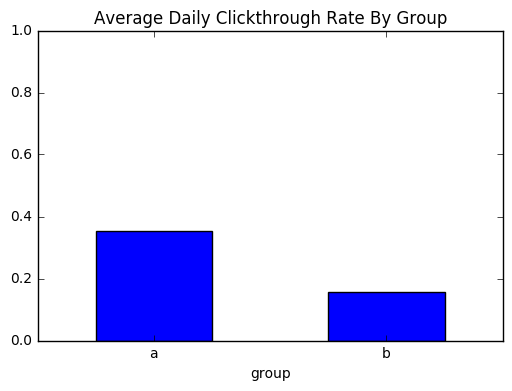

In [ ]:
diff = average_click_through_rate_by_group(df)
plot_grouped(diff,"Average Daily Clickthrough Rate By Group")

We can see that the a the click through rate in group a is almost two that of group b.

### Question 2.

We first get the number of result searches pages that were clicked on grouping by day, session_id and result_positon.  We do this using a group by as well as filtering the rows and only taking ones where the pages has been visited by looping through the rows and taking filtering:

In [ ]:
clicked = df.groupby([pd.TimeGrouper('D'),
                            'session_id',
                            'result_position']).apply(lambda row: len(row[row['result_position'] > 0]))

In [ ]:
clicked.head()

We note that the values in the series is the number of times that the result_positon appeared in the rows of the dataframe. We see that in session, 002b97995ca9ce77, they went to both the 3rd listed result and the 18th listed result. Let's take a look at the data for that session:

In [ ]:
df[df.session_id == '002b97995ca9ce77'].sort_index()

We can see that the person first checked out the 3rd result and then went back to the page and checked out the 18th search result.  We have to be careful that we only take the first result webpage the clicked on in the analysis.  I did this by first filtering the dataframe to only included rows where the person was checkin in and sorted by the time (index):

In [ ]:
visited_pages = df[df.action == 'visitPage'].sort_index()

Next we groupby the day and session_id and take the first result in the column corresponding to the 'result_position' column.  Since the dataframe is sorted we are assured that the result we get back is the first searche page the user clicked on:

In [ ]:
first_clicked = visited_pages.groupby([pd.TimeGrouper('D'),
                                       'session_id',], sort=True)['result_position'].first()

We print out the first few to see what the results look like:

In [ ]:
first_clicked.head()

As a sanity check we can see that the value for session_id 002b97995ca9ce77 is 3 which is what we expected.  Now we loop over the number of days and count page numbers that are first visited, and order them in order of the page number and ina bar plot:

In [ ]:
days = ['2016-03-01', '2016-03-02', '2016-03-03', '2016-03-04',
        '2016-03-05', '2016-03-06', '2016-03-07', '2016-03-08']

for day in days:
    
    first_clicked[day].value_counts().sort_index().plot(kind='bar')
    plt.xlabel(day)
    plt.ylabel('Count')
    plt.title('First Clicked Link')
    plt.show()

The first thing we see is that the first listed search result is the one that is most clicked and the number of click throughs on the rest of the results drop exponentially with the rank of the listing. This makes sense as the we usually only stay on the first page and hopefully the first returned search result is usually the relevant. Intersting things to note are that on the first day, someone first clicked on the 4087th result, that seems pretty strange and on the 4th day someone also clicked on the 414th search result, these are pretty big numbers and I'm not so sure why this could be.

The number of clickthroughs on the first result seem to be around 2400-2500 for the first three days. On the fourth day they drop to 2300, then drops down to 1700 on the fifth day and recovers to 2000 on the 6th and returns to the 2400-2500 range on the seventh day and finally dropping again to around 2200 on the eigth day. We can see that most days the first search results get about 2200-2500 clicks, but a noticable drop in click rate for the first search result occurs on the 5th day.  We can also see the same pattern occurs for the click rate on the second search result.

### Question 3. 

Now we are interested in looking at the daily zero rates, that is the the number of searches that return zero results. We group by the day and then count the number of rows that have,

    'n_results' == 0
    
and divide by the number of searches and get the zero rate. This is done in the function 
 
    average_zero_rate(...)

We plot this as a bar graph:

In [ ]:
rate = [average_zero_rate(df)]
plot_scalar(rate,'Average Daily Zeros Rate')

We now repeat the same process as above but also group by the group 'a' or 'b', this is done in the function,

    average_zero_rate_by_group(...)
    
We plot the results below,

In [ ]:
diff2 = average_zero_rate_by_group(df)
plot_grouped(diff,'Average Daily Zero Rate By Group')

We can see that the average zero rate is much higher in group a than group b, this is a little strange to me.  I would expect that the zero rate would be higher in group b since it has a smaller clickthrough rate.

### Question 4. 
Now we want to look into the session length. We first get the start time of each session by grouping by session_id, and taking the first row.  We have to use, <code>nth(0)</code> instead of, <code>first()</code> because of issues with it dropping cases with NaN.  We drop the uuid column since it seems like useless information and pushes the prints the table too wide.  The last thing I will mention is that we use the <code>as_index = False</code> in the <code>groupby(...)</code> call so that we get keep the original index and get back a Pandas dataframe instead of Pandas Series:

In [ ]:
session_begin = df.sort_index().groupby(['session_id'], sort=True, as_index=False).nth(0).drop('uuid',axis=1)
session_begin.sort_values('session_id').head()

Now, I'm going to do a sanity check.  I am going to look at the session 0001382e027b2ea4 and make sure that the first timestamp is the same as the one above for the same session_id.

In [ ]:
test_session = df[df.session_id == '0001382e027b2ea4'].sort_index().drop('uuid',axis=1)
test_session.head()

Our work passes the test!  In order to get the right answer for the last timestamp of each session, I had to drop the page_id column, I'm not 100% confident as to why this was necessary, but I think it has to do with the issues of NaNs.

In [ ]:
df2 = df.drop(['uuid','page_id'], axis=1).sort_index()

Now we do the same thing as previous for <code>session_begin</code>, but add take the <code>nth(-1)</code> instead of using <code>last()</code>

In [ ]:
session_end = df2.groupby(['session_id'],sort=True,as_index=False).nth(-1)
session_end.sort_values('session_id').head()

Now we prefrom another sanity check to make sure that the timestamp above for <code>session_id=0001382e027b2ea4</code> is the same as the last timestamp in the <code>test_session</code>:

In [ ]:
test_session.tail()

It worked!  So, lets now get the the start time of each session by creating a new column in the <code>session_begin</code> that strips the time from the index of the old dataframe, but we want to convert the Pandas Timestamp to Python DateTime objects, so we use the <code>to_pydatetime()</code> to do so:

In [ ]:
session_begin['time'] = session_begin.index.to_pydatetime()

Now we drop the timestamp as the index as well as the checkin column since that will be irrellevant and depends on the action.

In [ ]:
session_begin = session_begin.reset_index().drop(['timestamp','checkin'],axis=1)
session_begin.head()

Let's repeat the same process, but for <code>session_end</code>:

In [ ]:
session_end['time'] = session_end.index.to_pydatetime()
session_end = session_end.reset_index().drop(['timestamp','checkin'],axis=1)
session_end.head()

In [ ]:
df3 = pd.merge(session_begin, session_end, on='session_id',suffixes=('_start','_end'))
df3.head()

Get the time difference between the start and end times and then convert them integer values of the number of seconds.

In [ ]:
temp_session_length = df3['time_end'] - df3['time_start']
temp_session_length = temp_session_length.apply(lambda row: row.seconds)

Now we try to bin the number of counts of the session length into different bins up until 20 minutes,

In [ ]:
bins = [0,10,30,60,90,120,150,180,210,240]
time = 240
for i in range(16):
    time += 60
    bins.append(time)

top_session_lengths = temp_session_length.value_counts(bins=bins)

Now let's plot the session lengths,

In [ ]:
top_session_lengths.sort_index().plot(kind='bar', 
                                      title='Frequency Of Session Lengths')
plt.xlabel('Seconds')
plt.ylabel('Frequency')

We can see that most people, spend either 10 seconds in a session, which means they probably are not finding what they want. Then the next largest groups of people spend 30 seconds, 7 minutes and 0 seconds respectively.  Let's see if there is a difference between the session length and group.

In [ ]:
df3['session_length'] = temp_session_length
session_length_by_group = df3.groupby(['group_start'])['session_length'].value_counts(bins=bins)

In [ ]:
fig, ax = plt.subplots()
rects1 = session_length_by_group['a'].sort_index().plot(kind='bar',
                                                        color='b',
                                                        label='Group a')
rects2 = session_length_by_group['b'].sort_index().plot(kind='bar',
                                                        color='r',
                                                        label='Group b')
plt.ylabel('Count Of Sessions')
plt.xlabel('Session Length In Seconds')
plt.title('Session Length Between The Groups')
plt.legend()
plt.show()